# <center> Projekt-Seminar Deep Learing (Prof. Dr. Jörn Hees)

## <center> Grupppe: Simon Lausch, Jan Felix Fuchs, Paul Jansen und Tobias Pappen

## <center> Deep Reinforcement Learning (Atari Spiel Freeway)

## <center> Notebook von Paul Jansen

##



### Einführung in das Projekt und Notebook

Hinweis: Grundlegende informationen und Dokumentation zum Spiel gibt es in der Baseline Dokumentation
(https://github.com/TobiasPapen/projektSeminar)

Das folgende Notebook beinhaltet ein Deep Q-Learning Modell das auf der Baseline der Dreiergruppe basiert.

Abgrenzung zur Baseline:

* RGB Observation-Space (Baseline RAM Basiert)

* Observation-Space Cropped (Zuschneiden des RGB Bildes)

* Convolutional Neuronales Netz



Quellen:
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [ ]:
%pip install gym[atari]
%pip install ale_py
%pip install autorom[accept-rom-license]
%pip install torch
%pip install gym[box2d]
%pip install torchvision
%pip install matplotlib

In [45]:
import gym
import math
import random
import numpy as np
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [46]:
class ClipReward_2(gym.RewardWrapper):
    #Method to initialize the updated reward function
    def __init__(self, env, min_reward, max_reward):
        #Inheritance: calling construtor of the super class
        super().__init__(env)

        #Saving the given parameters
        self.pre_pos = 6                                    #previous position of the chicken (lowest value = 6)
        self.min_reward = min_reward                        #minimum reward
        self.max_reward = max_reward                        #maximum reward
        self.reward_range = (min_reward, max_reward)        #range of the reward
        self.target_runs = 0                                #number of target runs

    #Method to calculate the reward
    def reward(self, reward):
        #Recieving the RAM
        ram = env.unwrapped.ale.getRAM()
        #Saving the current position and the cooldown value of the chicken
        #The cooldown value is not zero if the chicken got hit, was reset and now needs to wait for a short time
        current_pos = ram[14]
        cooldown = ram[106]

        if(current_pos >= 175):
            #Chicken reaches the goal
            reward = reward_goal
            self.target_runs += 1
        elif(self.pre_pos > 6 and (not cooldown == 0)):
            #Chicken collides with a car (reset)
            #By checking the cooldown value we are making sure that the we detect a "false" collision
            #Otherwise the agent would get a negative reward for moving forwards and then immediately backwards)
            reward = reward_crash
        #Chicken recieves a reward connected to its current position on the road (independent from crash or goal)
        reward += current_pos - (500 / current_pos)

        #Getting new previous position
        self.pre_pos = current_pos
        #Returning reward
        return np.clip(reward, self.min_reward, self.max_reward)

    #Method to recieve the number target runs
    def get_TargetRuns(self):
        return self.target_runs

    #Method to reset the number of target runs
    def reset_TargetRuns(self):
        self.target_runs = 0

Convolutional Neural Network and RGB based Version:

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [47]:
#Network
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [48]:
env = ClipReward_2(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 0, obs_type = "rgb", render_mode = "rgb_array"), -10000, 10000)
#Enviroment mit Default Frameskip und einen RGB Observationspace als Rückgabe
env.reset()


(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 {'lives': 0, 'episode_frame_number': 0, 'frame_number': 0})

In [49]:
# Prüft ob Cuda verfügbar ist
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

False


1


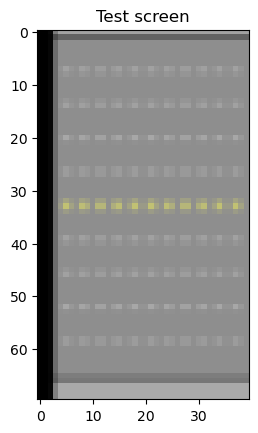

In [66]:
#Input Extracton / Transform
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=T.transforms.InterpolationMode.BILINEAR),
                    T.ToTensor()])
print("1")


def get_Chicken_location():
    return int(env.unwrapped.ale.getRAM()[14])  # MIDDLE OF CART

def get_screen():
    # env.Render übergibt ein RGB-Array
    # get_screen() transformiert dieses Array um Performanter zu Trainieren

    screen = env.render().transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # CROP image
    screen = T.functional.crop(screen, 20,0,175,100)
    size_h = T.functional.get_image_size(screen)[0]
    player_pos_prozent = (get_Chicken_location() / 175)
    #screen = T.functional.crop(screen, (size_h * player_pos_prozent)*100, 0,175,100)

    return resize(screen).unsqueeze(0)
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy())
plt.title('Test screen')
plt.show()

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
#Train
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []



In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
num_episodes = 0 #Anzahl Trainings durchläufe (50 norm)
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car
reward_l = [1,0]
target_l = [1,1]
for i_episode in range(num_episodes):
    reward_game = 0
    # Initialize the environment and state
    print(f"Durchlauf {i_episode} von {num_episodes}")
    env.reset()
    last_screen = get_screen()
    #print("get screen check")
    current_screen = get_screen()
    #print("get screen check2")
    state = current_screen - last_screen
    done = False
    count_frames = 0 # count frames of current Episonde (Game)
    while not done:
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward_game += reward
        #print(done)
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        count_frames += 1
        #print("get screen check3 " + str(count_frames))
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            reward_l.append(reward_game)
            target_runs = ClipReward_2.get_TargetRuns(env)
            target_l.append(target_runs)
            ClipReward_2.reset_TargetRuns(env)
            #episode_durations.append(count_frames + 1)
            #plot_durations()
            #break #Bricht training nach einen Durchlauf ab

        # Update the target network, copying all weights and biases in DQN
        if count_frames % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

print('Complete')
print(reward_l)
print(target_l)

x = np.arange(0, 2)
plt.plot(x, reward_l, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({num_episodes} games, eps. dec. = , lr = )")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()